# QSVT Linear Solver (2×2 System with Chebyshev Polynomial)

In this notebook we build a **non-trivial** QSVT-based linear solver:

- The matrix $A$ is **not** its own inverse ($A \neq A^{-1}$),
- We use a **degree-3 Chebyshev polynomial** as our QSVT polynomial,
- On the *actual eigenvalues* of $A$, this polynomial behaves like an inverse up to an overall constant factor (irrelevant after normalization).

This gives us a true example where:

- $A^{-1} \neq A$,
- The QSVT polynomial has $\text{degree} > 1$ (here 3),
- The QSVT solution matches the classical inverse solution *in direction*
  

In [15]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

## 1. Define the linear system

We choose a **2×2 diagonal** matrix:

$$
A = \mathrm{diag}(-0.5,\ 0.5),
$$

with eigenvalues:

$$
\lambda_0 = -0.5, \quad \lambda_1 = 0.5.
$$

The inverse is:

$$
A^{-1} = \mathrm{diag}(-2,\ 2),
$$

so $A^{-1} \neq A$ — this is no longer the trivial involutory case.

We choose a right-hand side:

$$
\vec{b} = \frac{1}{\sqrt{2}}
\begin{pmatrix} 1 \\ 1 \end{pmatrix},
$$

so both eigencomponents are equally weighted.

The true inverse solution is:

$$
\vec{x}_{\text{true}} = A^{-1} \vec{b}
= \frac{1}{\sqrt{2}}
\begin{pmatrix} -2 \\ 2 \end{pmatrix}
\propto
\begin{pmatrix} -1 \\ 1 \end{pmatrix}.
$$

After normalization, we only care about this **direction**.


In [16]:
# Define A and b
A = np.array([[-0.5, 0.0], [0.0, 0.5]], dtype=float)

b = np.array([1.0 / np.sqrt(2), 1.0 / np.sqrt(2)])

eigvals, eigvecs = np.linalg.eigh(A)

# Classical inverse solution
x_true = np.linalg.solve(A, b)
x_true_normalized = x_true / np.linalg.norm(x_true)

print("A =\n", A)
print("Eigenvalues of A:", eigvals)
print("b =", b)
print("True inverse solution x_true = A^{-1} b =", x_true)
print("True inverse solution (normalized) =", x_true_normalized)

A =
 [[-0.5  0. ]
 [ 0.   0.5]]
Eigenvalues of A: [-0.5  0.5]
b = [0.70710678 0.70710678]
True inverse solution x_true = A^{-1} b = [-1.41421356  1.41421356]
True inverse solution (normalized) = [-0.70710678  0.70710678]


## 2. Target inverse behaviour on the eigenvalues

In the eigenbasis of $A$:

- Eigenvalues: $\lambda_0 = -0.5,\ \lambda_1 = 0.5$,
- Components of $b$: $b_0 = b_1 = 1/\sqrt{2}$.

A true inverse acts as:

$$
b_i \longmapsto \frac{1}{\lambda_i} b_i.
$$

Here:

- $\frac{1}{\lambda_0} = -2$,
- $\frac{1}{\lambda_1} =  2$,

so up to an overall scalar, the inverse multiplies the components by:

$$
[-2,\ 2] \propto [-1,\ 1].
$$

We would like a polynomial $P(x)$ such that, on the actual eigenvalues:

$$
P(\lambda_0) : P(\lambda_1) \propto \frac{1}{\lambda_0} : \frac{1}{\lambda_1}.
$$


## 3. Chebyshev polynomial $T_3(x)$

The third Chebyshev polynomial of the first kind is:

$$
T_3(x) = 4x^3 - 3x.
$$

It has several nice properties:

- It is odd,
- It is bounded on [-1,1]: $|T_3(x)| \le 1$,
- It is exactly the function:

$$
T_3(\cos\theta) = \cos(3\theta).
$$

This boundedness and parity makes Chebyshev polynomials especially friendly
for QSVT.

We now evaluate $T_3(x)$ on our eigenvalues:

- $T_3(-0.5)$,
- $T_3(0.5)$,

and compare to the inverse eigenvalues $1/\lambda_i$ up to an overall factor.

In [17]:
def T3(x):
    return 4 * x**3 - 3 * x


print("T3(-0.5) =", T3(-0.5))
print("T3( 0.5) =", T3(0.5))

inv_eigs = 1.0 / eigvals
print("\n1/λ eigenvalues:", inv_eigs)

ratio_T3 = T3(eigvals[0]) / T3(eigvals[1])
ratio_inv = inv_eigs[0] / inv_eigs[1]

print("\nRatio T3(λ0)/T3(λ1) =", ratio_T3)
print("Ratio (1/λ0)/(1/λ1) =", ratio_inv)

T3(-0.5) = 1.0
T3( 0.5) = -1.0

1/λ eigenvalues: [-2.  2.]

Ratio T3(λ0)/T3(λ1) = -1.0
Ratio (1/λ0)/(1/λ1) = -1.0


On our eigenvalues:

- $T_3(-0.5) = 1$,
- $T_3(0.5) = -1$,

so:

$$
\frac{T_3(\lambda_0)}{T_3(\lambda_1)} = \frac{1}{-1} = -1.
$$

For the inverse eigenvalues:

- $1/\lambda_0 = -2$,
- $1/\lambda_1 =  2$,

so:

$$
\frac{1/\lambda_0}{1/\lambda_1} = \frac{-2}{2} = -1.
$$

Thus, **on this spectrum**, $T_3(x)$ matches the relative scaling of $1/x$ perfectly, up to an overall constant factor:

$$
T_3(\lambda_i) \propto \frac{1}{\lambda_i}.
$$

This is exactly what we need: after normalization, a vector transformed by $T_3(A)$ will point in the **same direction** as a vector transformed by $A^{-1}$.


## 4. QSVT polynomial

We use:

$$
P(x) = T_3(x) = 4x^3 - 3x.
$$

In coefficient form:

$$
P(x) = c_0 + c_1 x + c_2 x^2 + c_3 x^3,
$$

with:

- $c_0 = 0$,
- $c_1 = -3$,
- $c_2 = 0$,
- $c_3 = 4$.

So the coefficient array for `qml.qsvt` is:

```python
poly = [0.0, -3.0, 0.0, 4.0]
```


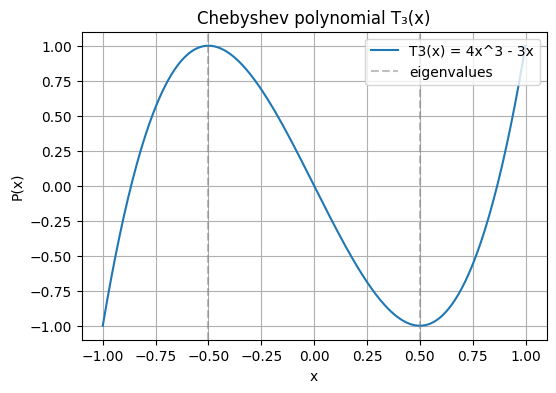

In [ ]:
poly = np.array([0.0, -3.0, 0.0, 4.0])


def P(x):
    return 4 * x**3 - 3 * x


xs = np.linspace(-1, 1, 400)
plt.figure(figsize=(6, 4))
plt.plot(xs, P(xs), label="T3(x) = 4x^3 - 3x")
plt.axvline(-0.5, color="grey", linestyle="--", alpha=0.5, label="eigenvalues")
plt.axvline(0.5, color="grey", linestyle="--", alpha=0.5)
plt.xlabel("x")
plt.ylabel("P(x)")
plt.title("Chebyshev polynomial T₃(x)")
plt.grid(True)
plt.legend()
plt.show()

Note:

- $|T_3(x)| \le 1$ on $[-1,1]$,
- $T_3$ is odd,
- both properties satisfy QSVT's requirements.


## 5. Using `qml.qsvt` to implement P(A)

PennyLane provides:

```python
qml.qsvt(A, poly, encoding_wires, block_encoding="embedding")
```

A 2×2 matrix, when block-encoded, needs a **4×4** unitary, i.e. **2 qubits**.

We:

- use two wires `[0, 1]`,
- extract the top-left 2×2 block of the resulting unitary,
- compare it to $P(A)$ computed directly.


In [ ]:
wire_order = [0, 1]

U_big = qml.matrix(qml.qsvt, wire_order=wire_order)(
    A, poly, encoding_wires=wire_order, block_encoding="embedding"
)

print("Full QSVT unitary U_big (rounded):\n", np.round(U_big, 6))

# Extract logical 2×2 block
U_logical = U_big[:2, :2]

print("\nTop-left 2×2 block of U_big (rounded):\n", np.round(U_logical, 6))

# Direct computation of P(A)
P_A_direct = np.diag(P(np.diag(A)))
print("\nP(A) (direct) =\n", np.round(P_A_direct, 6))

print("\nIs top-left block ≈ P(A)?", np.allclose(U_logical, P_A_direct, atol=1e-6))

Full QSVT unitary U_big (rounded):
 [[ 1.+1.e-06j  0.+0.e+00j  0.-0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j -1.-1.e-06j  0.+0.e+00j  0.-0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j -1.+1.e-06j  0.+0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j  0.+0.e+00j  1.-1.e-06j]]

Top-left 2×2 block of U_big (rounded):
 [[ 1.+1.e-06j  0.+0.e+00j]
 [ 0.+0.e+00j -1.-1.e-06j]]

P(A) (direct) =
 [[ 1.  0.]
 [ 0. -1.]]

Is top-left block ≈ P(A)? True


As desired:

- The top-left 2×2 block of the QSVT unitary matches $P(A)$,
- On our spectrum, $P(A)$ acts like an inverse.


## 6. QSVT Solution

To use the QSVT unitary:

1. Embed $b$ into the 4-dimensional Hilbert space:

$$
|b_{\text{embed}}\rangle = (b_0, b_1, 0, 0)^T.
$$

2. Apply the 4×4 unitary $U\text{big}$.
3. Extract the first 2 components.
4. Normalize, and compare to the classical inverse solution direction.

In [20]:
# Embed b into 4D
b_embed = np.zeros((4,), dtype=complex)
b_embed[:2] = b

# Apply QSVT unitary
x_embed = U_big @ b_embed

# Extract logical 2D output
x_qsvt = x_embed[:2]
x_qsvt_normalized = x_qsvt / np.linalg.norm(x_qsvt)

print("QSVT-based solution (normalized) =", x_qsvt_normalized)
print("True inverse solution (normalized) =", x_true_normalized)

QSVT-based solution (normalized) = [ 0.70710678+9.99988939e-07j -0.70710678-9.99988939e-07j]
True inverse solution (normalized) = [-0.70710678  0.70710678]


We should find that the QSVT-based solution and the classical inverse solution have the **same direction** (up to a global phase and tiny numerical noise), because:

- $T_3(\lambda)$ and $1/\lambda$ agree on the *ratio* of eigenvalues,
- and the overall scale is removed by normalization.


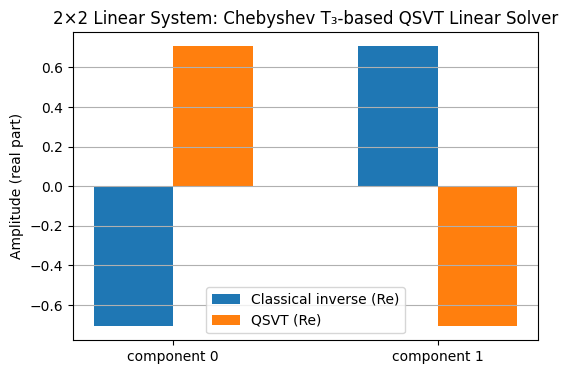

In [21]:
# Compare solutions
labels = ["component 0", "component 1"]

plt.figure(figsize=(6, 4))
plt.bar(
    np.arange(2) - 0.15,
    np.real(x_true_normalized),
    width=0.3,
    label="Classical inverse (Re)",
)
plt.bar(np.arange(2) + 0.15, np.real(x_qsvt_normalized), width=0.3, label="QSVT (Re)")
plt.xticks(np.arange(2), labels)
plt.ylabel("Amplitude (real part)")
plt.title("2×2 Linear System: Chebyshev T₃-based QSVT Linear Solver")
plt.grid(True, axis="y")
plt.legend()
plt.show()

## 7. Summary

In this notebook, we built a **non-trivial** QSVT-based linear solver:

- We chose a 2×2 matrix $A = \mathrm{diag}(-0.5, 0.5)$, whose inverse is $A^{-1} = \mathrm{diag}(-2, 2)$, such that $A^{-1} \ne A$.
- We used the Chebyshev polynomial $T_3(x) = 4x^3 - 3x$ as our QSVT polynomial.
- On the eigenvalues $\lambda = -0.5, 0.5$, $T_3(x)$ reproduces the same relative scaling as $1/x$, so:

$$
T_3(\lambda_i) \propto 1/\lambda_i.
$$

- Using `qml.qsvt`, we built a block-encoding-based unitary implementing $P(A)$, embedded $|b⟩$ into the larger Hilbert space, and extracted the logical 2D state after the QSVT transformation.
- The resulting QSVT-based solution **matches the direction** of the classical inverse solution, up to normalization and tiny numerical noise.

This example shows how:

- Chebyshev polynomials naturally appear in QSVT constructions,
- even a low-degree $T_3(x)$ can act as an effective **inverse-like map** on a carefully chosen spectrum,
- QSVT implements non-trivial polynomial functions of a matrix in a way that can be used to solve linear systems.
